# Graded Exercise #3

[EuroSAT](https://zenodo.org/records/7711810#.ZAm3k-zMKEA) is a land use and land cover classification dataset. The dataset is based on Sentinel-2 satellite imagery covering 13 spectral bands and consists of 10 Land Use and Land Cover (LULC) classes with a total of 27,000 labeled and geo-referenced images. 

Using the following code, you can create a DataFrame that includes columns detailing the center locations of the images and their corresponding Land Use and Land Cover (LULC) classes.

Your task: Perform **supervised Machine Learning (ML)** on this dataset. You should use **Dask** in your implementation. You may follow these key steps:
- Create relevant features and analyse them using some visualizations and statistical tools. You can start with features representing the mean and range of spectral bands in these images. You are free to explore more relevant features.
- Split the dataset into training, validation, and test sets.
- Choose an appropriate ML algorithm.
- Train and assess the model's performance.
- Adjust the model's hyperparameters to optimize its performance.

**Note**: 
- You can consider adding the extracted features as additional columns to this DataFrame.
- Start by considering the mean and range of spectral bands as features.

**Points of discussion**:
- Can you explain the criteria and rationale behind the features you created? What other features you would select from these images in addition to the mean and range?
- Why is it important to have separate sets for training, validation, and testing? Which split did you consider and why? 
- What factors influenced your choice of a specific machine learning algorithm?
- How did hyperparameter tuning impact the model's performance, and what were the final hyperparameter settings?
- What is the impact of using DASK to solve this problem? What is the impact of changing DASK parameters like chunk size? You may consider checking CPU, memory usage, processing time, ...

## Importing Necessary Modules

In [38]:
import rasterio
import rasterio.features
import rasterio.warp
import geojson
import numpy as np
import os
from os.path import isfile, join
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd

## Data Access

In [39]:
directory_path = '/data/shared/Big-Geodata-Processing-2023-1A/Exercise3/EuroSAT_MS/'
subfolders = [ f.path for f in os.scandir(directory_path) if f.is_dir() ]

## Creating Dataframe from the dataset

In [ ]:
# Define the function to get the centroid
def get_cent(filename):
    with rasterio.open(filename) as dataset:
        mask = dataset.dataset_mask()
        for geom, val in rasterio.features.shapes(mask, transform=dataset.transform):
            geom = rasterio.warp.transform_geom(dataset.crs, 'EPSG:4326', geom, precision=6)
            ls = list(geojson.utils.coords(geom))
            x = []
            y = []
            for row in ls:
                x.append(row[0])
                y.append(row[1])
            cent = [min(y) + (max(y) - min(y)) / 2, min(x) + (max(x) - min(x)) / 2]
    return cent

# Initialize the DataFrame
df_new = pd.DataFrame(columns=["Lat", "Lon", "Class"] + [f"Band_{i}_mean" for i in range(1, 14)] + [f"Band_{i}_min" for i in range(1, 14)] + [f"Band_{i}_max" for i in range(1, 14)])

# Loop through the folders and images
for i in range(len(subfolders)):
    image_path = subfolders[i]
    class_name = os.path.basename(image_path)
    all_images = [f for f in os.listdir(image_path) if os.path.isfile(join(image_path, f))]
    print(class_name, len(all_images))
    
    for j in range(len(all_images)):
        cent = get_cent(image_path+'/'+all_images[j])
        
        # Prepare lists for band statistics
        band_means = []
        band_mins = []
        band_maxs = []
        
        with rasterio.open(image_path+'/'+all_images[j]) as dataset:
            for k in range(1, 14):  # For bands 1 to 13
                band_data = dataset.read(k)
                band_means.append(np.mean(band_data))
                band_mins.append(np.min(band_data))
                band_maxs.append(np.max(band_data))
        
        # Create a new row with band statistics
        new_row = pd.DataFrame({
            "Lat": cent[0],
            "Lon": cent[1],
            "Class": class_name, 
            **{f"Band_{i}_mean": band_means[i - 1] if i <= len(band_means) else None for i in range(1, 14)},
            **{f"Band_{i}_min": band_mins[i - 1] if i <= len(band_mins) else None for i in range(1, 14)},
            **{f"Band_{i}_max": band_maxs[i - 1] if i <= len(band_maxs) else None for i in range(1, 14)}
        }, index=[0])
        
        # Concatenate the new row to the DataFrame
        df_new = pd.concat([df_new, new_row], ignore_index=True)

## Exporting Dataframe

In [ ]:
df_new.to_csv('Feature_Enginnered_Dataframe.csv')

## Reading New dataframe

In [40]:
df_new=  pd.read_csv('Feature_Enginnered_Dataframe.csv')

In [41]:
columns_to_keep = ['Lat', 'Lon', 'Class',
                   'Band_2_mean', 'Band_2_max', 'Band_2_min',
                   'Band_3_mean', 'Band_3_max', 'Band_3_min',
                   'Band_4_mean', 'Band_4_max', 'Band_4_min',
                   'Band_8_mean', 'Band_8_max', 'Band_8_min']

# Keep only the specified columns
df_new = df_new[columns_to_keep]

## Adding New Statistical Feature Column (Range)

In [42]:
bands_to_process = [2, 3, 4, 8]

for band in bands_to_process:
    min_col = f'Band_{band}_min'
    max_col = f'Band_{band}_max'
    range_col = f'Band_{band}_range'
    
    # Calculate the range and add it as a new column
    df_new[range_col] = df_new[max_col] - df_new[min_col]

## Adding New Composite Indices Column (NDVI, NDWI, SAVI, EVI)

In [43]:
# NDVI Calculation
df_new['NDVI_mean'] = (df_new['Band_8_mean'] - df_new['Band_4_mean']) / (df_new['Band_8_mean'] + df_new['Band_4_mean'])
df_new['NDVI_max'] = (df_new['Band_8_max'] - df_new['Band_4_min']) / (df_new['Band_8_max'] + df_new['Band_4_min'])
df_new['NDVI_min'] = (df_new['Band_8_min'] - df_new['Band_4_max']) / (df_new['Band_8_min'] + df_new['Band_4_max'])

# NDWI Calculation
df_new['NDWI_mean'] = (df_new['Band_3_mean'] - df_new['Band_8_mean']) / (df_new['Band_3_mean'] + df_new['Band_8_mean'])
df_new['NDWI_max'] = (df_new['Band_3_max'] - df_new['Band_8_min']) / (df_new['Band_3_max'] + df_new['Band_8_min'])
df_new['NDWI_min'] = (df_new['Band_3_min'] - df_new['Band_8_max']) / (df_new['Band_3_min'] + df_new['Band_8_max'])

# EVI Calculation
df_new['EVI_mean'] = 2.5 * (df_new['Band_8_mean'] - df_new['Band_4_mean']) / (df_new['Band_8_mean'] + (6 * df_new['Band_4_mean']) - (7.5 * df_new['Band_2_mean']) + 1)
df_new['EVI_max'] = 2.5 * (df_new['Band_8_max'] - df_new['Band_4_min']) / (df_new['Band_8_max'] + 6 * df_new['Band_4_max'] - 7.5 * df_new['Band_2_max'] + 1)
df_new['EVI_min'] = 2.5 * (df_new['Band_8_min'] - df_new['Band_4_max']) / (df_new['Band_8_min'] + 6 * df_new['Band_4_min'] - 7.5 * df_new['Band_2_min'] + 1)

# SAVI Calculation
df_new['SAVI_mean'] = (df_new['Band_8_mean'] - df_new['Band_4_mean']) * (1 + 1.5) / (df_new['Band_8_mean'] + df_new['Band_4_mean'] + 1.5)
df_new['SAVI_max'] = (df_new['Band_8_max'] - df_new['Band_4_min']) * (1 + 1.5) / (df_new['Band_8_max'] + df_new['Band_4_max'] + 1.5)
df_new['SAVI_min'] = (df_new['Band_8_min'] - df_new['Band_4_max']) * (1 + 1.5) / (df_new['Band_8_min'] + df_new['Band_4_min'] + 1.5)


In [44]:
df_new['NDVI_range'] = df_new['NDVI_max'] - df_new['NDVI_min']
df_new['NDWI_range'] = df_new['NDWI_max'] - df_new['NDWI_min']
df_new['EVI_range'] = df_new['EVI_max'] - df_new['EVI_min']
df_new['SAVI_range'] = df_new['SAVI_max'] - df_new['SAVI_min']

## Adding Index as the first column

In [45]:
# Create a new index column in the DataFrame
df_new.insert(0, 'Index', range(1, len(df_new) + 1))


In [46]:
df_new.tail(5)

,Index,Lat,Lon,Class,Band_2_mean,Band_2_max,Band_2_min,Band_3_mean,Band_3_max,Band_3_min,...,EVI_mean,EVI_max,EVI_min,SAVI_mean,SAVI_max,SAVI_min,NDVI_range,NDWI_range,EVI_range,SAVI_range
26995,26996,49.216428,16.408736,Highway,1181.477783,4581,756,1205.344727,4598,606,...,3.498450,7.139542,4.980459,0.912359,1.176780,-5.584283,1.452624,1.354466,2.159083,6.761063
26996,26997,49.082481,2.728486,Highway,1367.157959,2624,1015,1380.799316,2527,905,...,0.818692,10.659777,1.931366,0.545066,1.078061,-2.182949,1.064881,0.946983,8.728412,3.261010
26997,26998,37.763857,-3.719098,Highway,1755.214111,2645,1176,1903.738037,3015,1156,...,0.687585,1.573282,4.412305,0.411807,1.041382,-1.875854,0.993925,0.899038,-2.839023,2.917236
26998,26999,50.744405,4.544050,Highway,1004.707520,1633,767,952.972412,1717,558,...,193.353962,2.933867,0.831674,1.326305,1.642322,-1.766628,1.186247,1.065433,2.102193,3.408950
26999,27000,49.773664,9.171549,Highway,1149.998047,2778,903,1059.352051,2625,696,...,-11.560553,-33.012590,1.533333,0.825509,1.331520,-3.052396,1.269609,1.176845,-34.545923,4.383915


## Checking Column Names

In [47]:
df_new.columns

Index(['Index', 'Lat', 'Lon', 'Class', 'Band_2_mean', 'Band_2_max',
       'Band_2_min', 'Band_3_mean', 'Band_3_max', 'Band_3_min', 'Band_4_mean',
       'Band_4_max', 'Band_4_min', 'Band_8_mean', 'Band_8_max', 'Band_8_min',
       'Band_2_range', 'Band_3_range', 'Band_4_range', 'Band_8_range',
       'NDVI_mean', 'NDVI_max', 'NDVI_min', 'NDWI_mean', 'NDWI_max',
       'NDWI_min', 'EVI_mean', 'EVI_max', 'EVI_min', 'SAVI_mean', 'SAVI_max',
       'SAVI_min', 'NDVI_range', 'NDWI_range', 'EVI_range', 'SAVI_range'],
      dtype='object')

## Checking the Range of Latitude and Longitude

In [48]:
min_value_lat = df_new['Lat'].min()
max_value_lat = df_new['Lat'].max()

min_value_lon = df_new['Lon'].min()
max_value_lon= df_new['Lon'].max()

print(f"The lat min value is: {min_value_lat} and max: {max_value_lat}")
print(f"The lat min value is: {min_value_lon} and max: {max_value_lon}")

The lat min value is: 27.967059 and max: 65.2378165
The lat min value is: -20.993892 and max: 33.5289755


## Cleaning the data

In [55]:
rows_with_nan = df_new[df_new.isna().any(axis=1)]

print("Rows with NaN values:")
print(rows_with_nan)

df_check = df_new[['NDVI_mean', 'NDVI_max', 'NDVI_min', 'NDWI_mean', 'NDWI_max',
       'NDWI_min', 'EVI_mean', 'EVI_max', 'EVI_min', 'SAVI_mean', 'SAVI_max',
       'SAVI_min', 'NDVI_range', 'NDWI_range', 'EVI_range', 'SAVI_range']]

for column_name in df_check.columns:
    inf_count = np.isinf(df_new[column_name]).sum()
    print(f'Number of infinite values in column "{column_name}": {inf_count}')
    

rows_with_inf = df_check[df_check.apply(lambda x: np.any(np.isinf(x)), axis=1)]

print("Rows with infinite values:")
print(rows_with_inf)


Rows with NaN values:
Empty DataFrame
Columns: [Index, Lat, Lon, Class, Band_2_mean, Band_2_max, Band_2_min, Band_3_mean, Band_3_max, Band_3_min, Band_4_mean, Band_4_max, Band_4_min, Band_8_mean, Band_8_max, Band_8_min, Band_2_range, Band_3_range, Band_4_range, Band_8_range, NDVI_mean, NDVI_max, NDVI_min, NDWI_mean, NDWI_max, NDWI_min, EVI_mean, EVI_max, EVI_min, SAVI_mean, SAVI_max, SAVI_min, NDVI_range, NDWI_range, EVI_range, SAVI_range]
Index: []

[0 rows x 36 columns]
Number of infinite values in column "NDVI_mean": 0
Number of infinite values in column "NDVI_max": 0
Number of infinite values in column "NDVI_min": 0
Number of infinite values in column "NDWI_mean": 0
Number of infinite values in column "NDWI_max": 0
Number of infinite values in column "NDWI_min": 0
Number of infinite values in column "EVI_mean": 0
Number of infinite values in column "EVI_max": 0
Number of infinite values in column "EVI_min": 0
Number of infinite values in column "SAVI_mean": 0
Number of infinite val

In [50]:
df_new = df_new.drop(7212)
df_new = df_new.drop(11513)
df_new = df_new.drop(22820)

## Plotting 

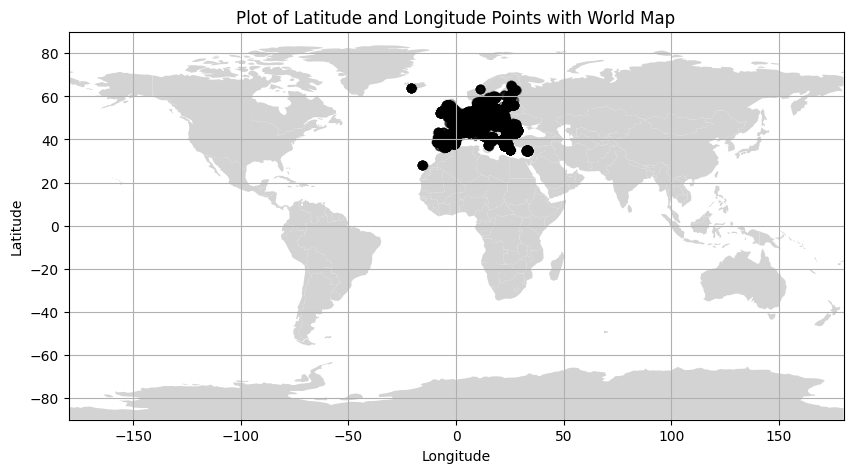

In [51]:
# Load world map data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract latitude and longitude columns
lats = df_new['Lat']
lons = df_new['Lon']

# Plotting the points on a scatter plot
plt.figure(figsize=(10, 8))

# Plot the world map
world.plot(ax=plt.gca(), color='lightgrey')

# Scatter plot of latitude and longitude
plt.scatter(lons, lats, alpha=0.1, color='black')  # Plotting latitude vs longitude

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Plot of Latitude and Longitude Points with World Map')

# Set axis limits to simulate zoom level (adjust these values to zoom in or out)
# For example, latitude from -90 to 90 and longitude from -180 to 180 will cover the whole world
plt.xlim(-180, 180)  # Set longitude limits
plt.ylim(-90, 90)  # Set latitude limits

plt.grid(True)
plt.show()

In [52]:
import geopandas as gpd

# Define the latitude and longitude ranges
lat_min_1 = 27.967059
lat_max_1 = 65.2378165
lat_min_2 = -20.993892
lat_max_2 = 33.5289755

# Load the world boundaries dataset from Natural Earth
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter countries within the latitude and longitude ranges
countries_in_range_1 = world.cx[:, lat_min_1:lat_max_1]
countries_in_range_2 = world.cx[:, lat_min_2:lat_max_2]

# Print the countries within the specified latitude ranges
print("Countries in the first latitude range:")
print(countries_in_range_1['name'])

print("\nCountries in the second latitude range:")
print(countries_in_range_2['name'])


Countries in the first latitude range:
3                        Canada
4      United States of America
5                    Kazakhstan
6                    Uzbekistan
18                       Russia
                 ...           
170            Bosnia and Herz.
171             North Macedonia
172                      Serbia
173                  Montenegro
174                      Kosovo
Name: name, Length: 79, dtype: object

Countries in the second latitude range:
0                          Fiji
1                      Tanzania
2                     W. Sahara
4      United States of America
7              Papua New Guinea
                 ...           
167                  Somaliland
168                      Uganda
169                      Rwanda
175         Trinidad and Tobago
176                    S. Sudan
Name: name, Length: 114, dtype: object


In [53]:
df_new.to_csv('Added_Features.csv')

In [56]:
df_new.head()

,Index,Lat,Lon,Class,Band_2_mean,Band_2_max,Band_2_min,Band_3_mean,Band_3_max,Band_3_min,...,EVI_mean,EVI_max,EVI_min,SAVI_mean,SAVI_max,SAVI_min,NDVI_range,NDWI_range,EVI_range,SAVI_range
0,1,51.636699,0.409756,Residential,1087.174316,1937,885,901.169434,2204,639,...,-1.166532,1.213046,1.751178,0.859790,1.309091,-4.092290,1.363916,1.175227,-0.538132,5.401381
1,2,43.677658,7.113914,Residential,1166.122559,2533,798,1116.608887,2852,608,...,145.499145,1.960423,2.178088,1.020737,1.338696,-2.936158,1.276710,1.143255,-0.217665,4.274854
2,3,51.630671,-0.732539,Residential,1051.750732,2294,804,984.232178,2006,670,...,-7.943372,7.491744,1.152913,1.200299,1.571092,-2.132988,1.223213,1.066615,6.338831,3.704080
3,4,52.333435,8.017260,Residential,1042.374756,1865,799,868.225586,1635,527,...,-2.023623,5.711784,0.869874,1.006356,1.697019,-3.279829,1.376221,1.251078,4.841910,4.976848
4,5,43.730154,7.160103,Residential,1042.529053,5556,674,970.184570,5567,460,...,-20.958015,6.879911,7.132075,1.177845,1.577770,-7.063220,1.581873,1.556458,-0.252165,8.640990
